In [2]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 533.9 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 88.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.7 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 56.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 82.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 14.1 MB/s eta 

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sagemaker
import os
from sagemaker.tensorflow import TensorFlow
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

print('Done')

2024-04-26 17:14:09.026876: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 17:14:10.439945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Done


In [4]:
train = pd.read_csv("dataset.csv", sep=",")
train.head()

,selected_text,sentiment
0,have responded if were going,0
1,sooo sad,1
2,bullying me,1
3,leave me alone,1
4,sons of,1


## Converting labels into categrical type

In [5]:
labels = tf.keras.utils.to_categorical(train["sentiment"], 3)

In [6]:
X = np.array(train["selected_text"])

In [7]:
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [8]:
X

array(['have responded if were going', 'sooo sad', 'bullying me', ...,
       'yay good for both of you', 'but it was worth it',
       'all this flirting going on the atg smiles yay hugs'], dtype=object)

## Creating a session object and uploading data to S3

In [9]:
sage_maker_session = sagemaker.Session()

In [10]:
#This return the complete s3 path of the data file.
prefix = "tensorflow-sentiment-predictions"
dataset_input_path = sage_maker_session.upload_data("dataset.csv",key_prefix=prefix+"/dataset")

In [11]:
dataset_input_path

's3://sagemaker-us-east-1-049050117250/tensorflow-sentiment-predictions/dataset/dataset.csv'

In [12]:
import boto3
from sagemaker import get_execution_role

role = get_execution_role()
bucket = 'sagemaker-eu-north-1-049050117250'
data_key = 'tensorflow-sentiment-predictions/dataset/dataset.csv'
data_location = 's3://sagemaker-eu-north-1-049050117250/tensorflow-sentiment-predictions/dataset/dataset.csv'.format(bucket,data_key)
dataset = pd.read_csv(data_location)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [13]:
dataset

,selected_text,sentiment
0,have responded if were going,0
1,sooo sad,1
2,bullying me,1
3,leave me alone,1
4,sons of,1
...,...,...
27476,lost,1
27477,don force,1
27478,yay good for both of you,2
27479,but it was worth it,2


## Transforming all feature values into string type (Not to get errors)

In [14]:
labels = dataset["sentiment"].values
features = dataset["selected_text"].values
X=[]
for i in range(len(features)):
    X.append(str(features[i]))

In [15]:
X[:5]

['have responded if were going',
 'sooo sad',
 'bullying me',
 'leave me alone',
 'sons of']

## Building train.py 

In [16]:
%%writefile train.py
import argparse
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=40)
    parser.add_argument('--max_words', type=int, default=5000)
    parser.add_argument('--max_len', type=int, default=200)
    parser.add_argument('--gpu_count', type=int, default=os.environ['SM_NUM_GPUS'])

    # input data and model directories
    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args, _ = parser.parse_known_args()
    
    epochs     = args.epochs
    max_words  = args.max_words
    max_len    = args.max_len
    gpu_count  = args.gpu_count
    model_dir  = args.model_dir
    training_dir   = args.train
    
    data = pd.read_csv(training_dir+'/dataset.csv',sep=',')

    labels = data['sentiment'].values
    labels = tf.keras.utils.to_categorical(labels, 3, dtype="float32")
    features = data['selected_text'].values
    X = []
    for i in range(len(features)):
        X.append(str(features[i]))
    
    #Tokenizing data and making them sequences
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X)
    sequences = tokenizer.texts_to_sequences(X)
    features = pad_sequences(sequences, maxlen=max_len)
    
    #Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(features,labels, random_state=0)
    print (len(X_train),len(X_test),len(y_train),len(y_test))

    # Building the model
    model = Sequential()
    model.add(layers.Embedding(max_words, 40, input_length=max_len))
    model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
    model.add(layers.Dense(3,activation='softmax'))
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))
    
    #Validating model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('Model accuracy: ',test_acc)
    
    model_path = '{}/{}/001'.format(model_dir, 'tensorflow-sentiment-predictions')
    tf.saved_model.save(model, model_path)

Overwriting train.py


### Note1

fit_on_texts: Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

texts_to_sequences: Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

Why don't combine them? Because you almost always fit once and convert to sequences many times. You will fit on your training corpus once and use that exact same word_index dictionary at train / eval / testing / prediction time to convert actual text into sequences to feed them to the network. So it makes sense to keep those methods separate.

### Note2

pad_sequences is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.

For example:

pad_sequences([[1, 2, 3], [3, 4, 5, 6], [7, 8]])

Output:

array([[0, 1, 2, 3],
       [3, 4, 5, 6],
       [0, 0, 7, 8]], dtype=int32)

In [17]:
#Checking TF version - it must be > 2.0
tf_version = tf.__version__
tf_version

'2.16.1'

In [18]:
from sagemaker.session import Session

sagemaker_session = Session()
boto_sess = boto3.Session()

region = boto_sess.region_name

In [19]:
role = sagemaker.get_execution_role()

In [ ]:
pip install tensorflow==2.8 # fit method didn't work with tensorflow 2.16.1 so changed to 2.8

In [27]:
model_dir = '/opt/ml/model'
tf_estimator = TensorFlow(entry_point='train.py',
                          role=role,
                          model_dir=model_dir,
                          instance_count=1, 
                          instance_type='local',
                          framework_version="2.8", 
                          py_version='py39',
                          script_mode = True,
                          hyperparameters={
                              "epochs":5
                          }
                         )

In [28]:
#Starting the training, calling the fit method and passing the training data path. 
#This creates a training job on SageMaker. 
tf_estimator.fit({'train': dataset_input_path})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2024-04-26-17-16-43-383
INFO:sagemaker.local.image:'Docker Compose' is not installed. Proceeding to check for 'docker-compose' CLI.
INFO:sagemaker.local.image:'Docker Compose' found using Docker Compose CLI.
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-ubu9e:
    command: train
    container_name: qzlgofecxq-algo-1-ubu9e
    environment:
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2

Login Succeeded


INFO:sagemaker.local.image:image pulled: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.8-cpu-py39
INFO:sagemaker.local.image:docker command: docker-compose -f /tmp/tmphop38_as/docker-compose.yaml up --build --abort-on-container-exit


 Container qzlgofecxq-algo-1-ubu9e  Creating
 Container qzlgofecxq-algo-1-ubu9e  Created
Attaching to qzlgofecxq-algo-1-ubu9e
qzlgofecxq-algo-1-ubu9e  | 2024-04-26 17:18:40.605821: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
qzlgofecxq-algo-1-ubu9e  | 2024-04-26 17:18:40.606720: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
qzlgofecxq-algo-1-ubu9e  | 2024-04-26 17:18:40.678896: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
qzlgofecxq-algo-1-ubu9e  | 2024-04-26 17:18:44,582 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
qzlgofecxq-algo-1-ubu9e  | 2024-04-26 17:18:44,593 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
qzlgofecxq-algo-1-ubu9e  | 2024-04-26 17

INFO:root:creating /tmp/tmphop38_as/artifacts/output/data
INFO:root:copying /tmp/tmphop38_as/algo-1-ubu9e/output/success -> /tmp/tmphop38_as/artifacts/output
INFO:root:creating /tmp/tmphop38_as/artifacts/model/tensorflow-sentiment-predictions
INFO:root:creating /tmp/tmphop38_as/artifacts/model/tensorflow-sentiment-predictions/001
INFO:root:creating /tmp/tmphop38_as/artifacts/model/tensorflow-sentiment-predictions/001/variables
INFO:root:copying /tmp/tmphop38_as/model/tensorflow-sentiment-predictions/001/variables/variables.data-00000-of-00001 -> /tmp/tmphop38_as/artifacts/model/tensorflow-sentiment-predictions/001/variables
INFO:root:copying /tmp/tmphop38_as/model/tensorflow-sentiment-predictions/001/variables/variables.index -> /tmp/tmphop38_as/artifacts/model/tensorflow-sentiment-predictions/001/variables
INFO:root:creating /tmp/tmphop38_as/artifacts/model/tensorflow-sentiment-predictions/001/assets
INFO:root:copying /tmp/tmphop38_as/model/tensorflow-sentiment-predictions/001/saved_m

qzlgofecxq-algo-1-ubu9e exited with code 0
Aborting on container exit...
 Container qzlgofecxq-algo-1-ubu9e  Stopping
 Container qzlgofecxq-algo-1-ubu9e  Stopped


INFO:sagemaker.local.image:===== Job Complete =====


## Deploying the model to SageMaker

In [29]:
endpoint_name = 'tensorflow-sentiment-predictions'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
end_point = tf_estimator.deploy(initial_instance_count=1,instance_type='ml.p2.xlarge',endpoint_name=endpoint_name)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-training-2024-04-26-18-02-10-145
INFO:sagemaker:Creating endpoint-config with name tensorflow-sentiment-predictions2024-04-26-18-02-10
INFO:sagemaker:Creating endpoint with name tensorflow-sentiment-predictions2024-04-26-18-02-10
INFO:sagemaker.local.image:'Docker Compose' is not installed. Proceeding to check for 'docker-compose' CLI.
INFO:sagemaker.local.image:'Docker Compose' found using Docker Compose CLI.
INFO:sagemaker.local.image:serving
INFO:sagemaker.local.image:creating hosting dir in /tmp/tmpiyo3fugu
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

INFO:sagemaker.local.image:docker command: docker pull 763104351884.dkr.ecr.us-east-1

Login Succeeded


INFO:sagemaker.local.image:image pulled: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.8-gpu
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-zc4w2:
    command: serve
    container_name: 1o8l74yrvv-algo-1-zc4w2
    environment:
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.8-gpu
    networks:
      sagemaker-local:
        aliases:
        - algo-1-zc4w2
    ports:
    - 8080:8080
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmp4nq_kpdh:/opt/ml/model
version: '2.3'

INFO:sagemaker.local.image:docker command: docker-compose -f /tmp/tmpiyo3fugu/docker-compose.yaml up --build --abort-on-container-exit
INFO:sagemaker.loc

Attaching to 1o8l74yrvv-algo-1-zc4w2


INFO:sagemaker.local.entities:Checking if serving container is up, attempt: 10
INFO:sagemaker.local.entities:Container still not up, got: -1


1o8l74yrvv-algo-1-zc4w2  | INFO:__main__:PYTHON SERVICE: False
1o8l74yrvv-algo-1-zc4w2  | INFO:__main__:starting services
1o8l74yrvv-algo-1-zc4w2  | INFO:__main__:using default model name: tensorflow-sentiment-predictions
1o8l74yrvv-algo-1-zc4w2  | INFO:__main__:tensorflow serving model config: 
1o8l74yrvv-algo-1-zc4w2  | model_config_list: {
1o8l74yrvv-algo-1-zc4w2  |   config: {
1o8l74yrvv-algo-1-zc4w2  |     name: 'tensorflow-sentiment-predictions'
1o8l74yrvv-algo-1-zc4w2  |     base_path: '/opt/ml/model/tensorflow-sentiment-predictions'
1o8l74yrvv-algo-1-zc4w2  |     model_platform: 'tensorflow'
1o8l74yrvv-algo-1-zc4w2  |     model_version_policy: {
1o8l74yrvv-algo-1-zc4w2  |       specific: {
1o8l74yrvv-algo-1-zc4w2  |         versions: 1
1o8l74yrvv-algo-1-zc4w2  |       }
1o8l74yrvv-algo-1-zc4w2  |     }
1o8l74yrvv-algo-1-zc4w2  |   }
1o8l74yrvv-algo-1-zc4w2  | }
1o8l74yrvv-algo-1-zc4w2  | 
1o8l74yrvv-algo-1-zc4w2  | 
1o8l74yrvv-algo-1-zc4w2  | INFO:__main__:tensorflow version in

INFO:sagemaker.local.entities:Checking if serving container is up, attempt: 15
INFO:sagemaker.local.entities:Container still not up, got: -1


1o8l74yrvv-algo-1-zc4w2  | WARNING:urllib3.connectionpool:Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb143da84f0>: Failed to establish a new connection: [Errno 111] Connection refused')': /v1/models/tensorflow-sentiment-predictions
1o8l74yrvv-algo-1-zc4w2  | 2024-04-26 18:09:18.242888: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /opt/ml/model/tensorflow-sentiment-predictions/001
1o8l74yrvv-algo-1-zc4w2  | 2024-04-26 18:09:18.933268: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 3804370 microseconds.
1o8l74yrvv-algo-1-zc4w2  | 2024-04-26 18:09:19.010199: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /opt/ml/model/tensorflow-sentiment-predictio

INFO:sagemaker.local.entities:Checking if serving container is up, attempt: 20


1o8l74yrvv-algo-1-zc4w2  | 2024/04/26 18:09:22 [warn] 51#51: *1 js: r.responseBody is deprecated and will be removed in the future
1o8l74yrvv-algo-1-zc4w2  | 172.18.0.1 - - [26/Apr/2024:18:09:22 +0000] "GET /ping HTTP/1.1" 200 0 "-" "python-urllib3/2.2.1"
!

In [30]:
print(end_point.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


tensorflow-sentiment-predictions2024-04-26-18-02-10


## Validating the model

In [31]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


In [33]:
X_test[:10]

['wish',
 'gosh today sucks',
 'tired and didn really have an exciting saturday oh well hope it better tomorrow',
 've been eating cheetos all morning',
 'haiiii sankq fineee ima js get checkup cos my rib hurts lol idk but shall be fine thanks',
 'congrats',
 'loved',
 'in weho they re are playing lot of brit',
 'oh only in my just joined twitter few days ago',
 'awww wish was there']

### Recreating the tokenizer

In [37]:
import pickle

def preprocess_texts(text):
    
    max_words=5000
    max_len = 200
    
    tokenizer =Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X)
    sequences = tokenizer.texts_to_sequences(text)
    sequences = pad_sequences(sequences,maxlen=max_len)
    
    #saving tokenizer 
    with open("tokenizer.pickle","wb") as handle:
        pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)
        
    return sequences

### Note3
use pickle.dump() function to store the object data to the file.

pickle.dump() function takes 3 arguments. 
* The first argument is the object that you want to store.
* The second argument is the file object you get by opening the desired file in write-binary (wb) mode.
* And the third argument is the key-value argument. This argument defines the protocol. There are two type of protocol - pickle.HIGHEST_PROTOCOL and pickle.DEFAULT_PROTOCOL.

In [38]:
test_text = preprocess_texts(X_test)

In [39]:
len(test_text)

6871

# Inferencing on test text 

In [41]:
predictions = end_point.predict(test_text)

1o8l74yrvv-algo-1-zc4w2  | 2024/04/26 18:21:56 [warn] 50#50: *3 js: r.requestBody is deprecated and will be removed in the future
1o8l74yrvv-algo-1-zc4w2  | 2024-04-26 18:21:57.068963: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219872000 exceeds 10% of free system memory.
1o8l74yrvv-algo-1-zc4w2  | 2024-04-26 18:21:57.146601: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219872000 exceeds 10% of free system memory.
1o8l74yrvv-algo-1-zc4w2  | 2024-04-26 18:21:57.365886: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219872000 exceeds 10% of free system memory.
1o8l74yrvv-algo-1-zc4w2  | 2024-04-26 18:21:57.365974: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 219872000 exceeds 10% of free system memory.
1o8l74yrvv-algo-1-zc4w2  | 2024-04-26 18:21:57.711706: W external/org_tensorflow/tensorflow/core/frame

In [42]:
np.around(predictions["predictions"],decimals=0).argmax(axis=1)

array([2, 1, 2, ..., 1, 0, 1])

In [43]:
y_test

array([2, 1, 0, ..., 2, 0, 0])

### Plotting the confusion matrix

This time trained only for 5 epochs 


INFO:matplotlib.font_manager:generated new fontManager
/tmp/ipykernel_8323/1908487825.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


<Axes: >

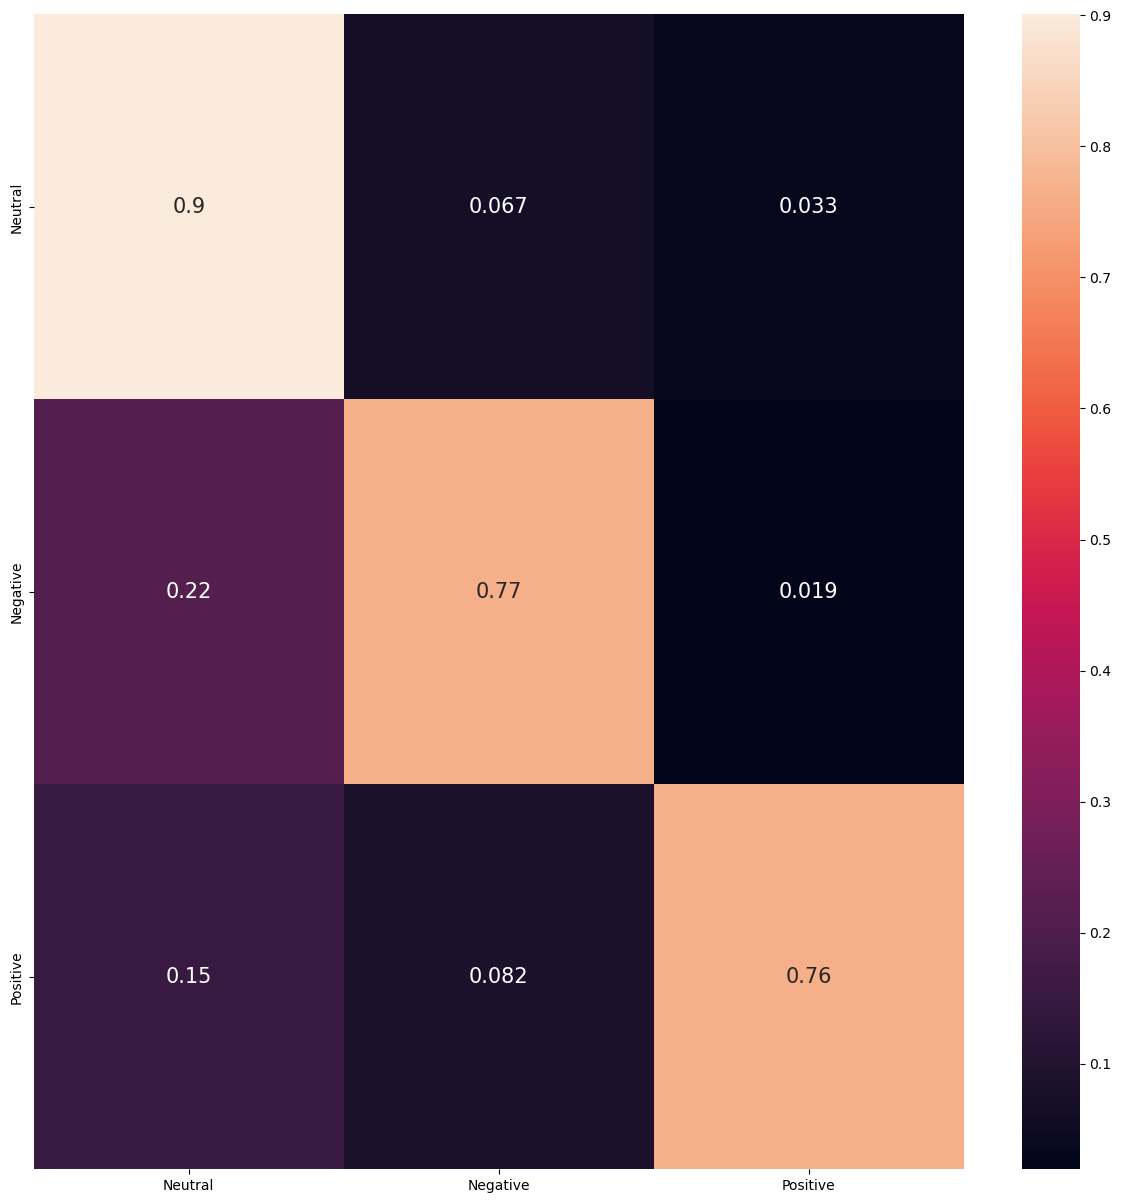

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
matrix = confusion_matrix(y_test,np.around(predictions["predictions"],decimals=0).argmax(axis=1))#np.argmax finds the max value along the axis and returns the index of that value
conf_matrix = pd.DataFrame(matrix,index = ["Neutral","Negative","Positive"],columns=["Neutral","Negative","Positive"])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})
    

In [47]:
sentiment = ['Neutral','Negative','Positive']

In [48]:
#loading tokenizer
with open("tokenizer.pickle","rb") as handle:
    tokenizer= pickle.load(handle)
    
sequence = tokenizer.texts_to_sequences(["this data science project is the best ever"])
test = pad_sequences(sequence,maxlen=200)
test = end_point.predict(test)
sentiment[np.around(test["predictions"],decimals=0).argmax(axis=1)[0]]

1o8l74yrvv-algo-1-zc4w2  | 2024/04/26 18:34:47 [warn] 51#51: *5 js: r.requestBody is deprecated and will be removed in the future


'Positive'

1o8l74yrvv-algo-1-zc4w2  | 172.18.0.1 - - [26/Apr/2024:18:34:47 +0000] "POST /invocations HTTP/1.1" 200 68 "-" "python-urllib3/2.2.1"


In [49]:
sequence = tokenizer.texts_to_sequences(["i hate when i wake up early"])
test = pad_sequences(sequence,maxlen=200)
test = end_point.predict(test)
sentiment[np.around(test["predictions"],decimals=0).argmax(axis=1)[0]]

1o8l74yrvv-algo-1-zc4w2  | 172.18.0.1 - - [26/Apr/2024:18:35:25 +0000] "POST /invocations HTTP/1.1" 200 68 "-" "python-urllib3/2.2.1"


'Negative'

In [50]:
#to delete model endpoint:

#end_point.delete_endpoint()